# Join Analysis: New Transactions to Awards

This notebook:
1. Loads the most recent transaction and award datasets
2. Identifies new awards vs modifications in transactions (using eda-3 methodology)
3. Filters to only new transactions
4. Joins new transactions to awards by award_id
5. Analyzes match rate: how many transactions find their award vs not found

## Setup

In [1]:
1+1

2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import glob

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Most Recent Datasets

In [3]:
def find_most_recent_file(data_dir, pattern):
    """Find the most recent file matching pattern in data_dir"""
    files = glob.glob(str(Path(data_dir) / pattern))
    if not files:
        return None
    # Sort by modification time, most recent first
    files.sort(key=lambda x: Path(x).stat().st_mtime, reverse=True)
    return files[0]

# Look for most recent normalized datasets
data_dir = Path('../data/awards')

transactions_file = find_most_recent_file(data_dir, 'transactions_normalized_*.json')
awards_file = find_most_recent_file(data_dir, 'awards_normalized_*.json')

print("=== Available Datasets ===")
if transactions_file:
    print(f"Most recent transactions: {Path(transactions_file).name}")
if awards_file:
    print(f"Most recent awards: {Path(awards_file).name}")

if not transactions_file or not awards_file:
    raise FileNotFoundError("Need both transaction and award datasets!")

=== Available Datasets ===
Most recent transactions: transactions_normalized_2026-01-08_22-52-58.json
Most recent awards: awards_normalized_2026-01-08_22-55-59.json


In [4]:
# Load transactions
print("=== Loading Transactions ===")
with open(transactions_file, 'r') as f:
    transactions_data = json.load(f)

transactions_df = pd.DataFrame(transactions_data)

print(f"Loaded {len(transactions_df):,} transactions")
print(f"Shape: {transactions_df.shape}")
print(f"Columns: {transactions_df.shape[1]}")

=== Loading Transactions ===
Loaded 7,952 transactions
Shape: (7952, 22)
Columns: 22


In [5]:
# Load awards
print("=== Loading Awards ===")
with open(awards_file, 'r') as f:
    awards_data = json.load(f)

awards_df = pd.DataFrame(awards_data)

print(f"Loaded {len(awards_df):,} awards")
print(f"Shape: {awards_df.shape}")
print(f"Columns: {awards_df.shape[1]}")

=== Loading Awards ===
Loaded 7,251 awards
Shape: (7251, 18)
Columns: 18


In [33]:
awards_df.award_amount > 9

0      40399143444.29
1      39308850163.32
2      38984198544.78
3      32180570320.81
4      31739749798.38
            ...      
7246        900916.81
7247        900132.04
7248        900000.00
7249        900000.00
7250        900000.00
Name: award_amount, Length: 7251, dtype: float64

## Identify New Awards vs Modifications

Following the methodology from eda-3.ipynb:
- **New awards**: `modification_number == '0'` OR `action_type_description == 'NEW'`
- **Modifications**: Everything else

In [6]:
# Check key fields
print("=== Transaction Fields for Filtering ===")
print(f"\nModification Number - Top 10:")
print(transactions_df['modification_number'].value_counts().head(10))

print(f"\nAction Type Description - All values:")
print(transactions_df['action_type_description'].value_counts())

=== Transaction Fields for Filtering ===

Modification Number - Top 10:
modification_number
0         673
P00001    613
P00002    508
P00003    477
P00004    440
P00005    384
P00006    359
P00007    317
P00008    285
P00009    253
Name: count, dtype: int64

Action Type Description - All values:
action_type_description
REVISION              2475
CONTINUATION          1617
M                     1482
G                     1018
Unknown                673
FUNDING_ADJUSTMENT     323
K                      279
F                       30
NEW                     30
L                       16
V                        3
T                        2
CORRECTION               1
S                        1
Y                        1
N                        1
Name: count, dtype: int64


In [7]:
# Apply the filter from eda-3
new_transactions = transactions_df[
    (transactions_df['modification_number'] == '0') | 
    (transactions_df['action_type_description'] == 'NEW')
]

modifications = transactions_df[
    (transactions_df['modification_number'] != '0') & 
    (transactions_df['action_type_description'] != 'NEW')
]

print("=== Transaction Filtering Results ===")
print(f"Total transactions: {len(transactions_df):,}")
print(f"New transactions: {len(new_transactions):,} ({len(new_transactions)/len(transactions_df)*100:.1f}%)")
print(f"Modifications: {len(modifications):,} ({len(modifications)/len(transactions_df)*100:.1f}%)")

print(f"\nNew transactions total value: ${new_transactions['federal_action_obligation'].sum():,.2f}")
print(f"New transactions avg value: ${new_transactions['federal_action_obligation'].mean():,.2f}")

=== Transaction Filtering Results ===
Total transactions: 7,952
New transactions: 703 (8.8%)
Modifications: 7,249 (91.2%)

New transactions total value: $19,483,131,451.53
New transactions avg value: $27,714,269.49


In [27]:
transactions_df.federal_action_obligation.sort_values(ascending=True)

1749   -108716118.00
1410    -35000000.00
3148    -33268467.00
6117    -25279097.47
2316    -22483184.27
            ...     
3089    921744317.00
47     1062977660.85
4690   1495000000.00
2274   1572516500.00
280    1679170000.00
Name: federal_action_obligation, Length: 7952, dtype: float64

In [32]:
transactions_df[transactions_df.federal_action_obligation > 100_000].federal_action_obligation.sort_values(ascending=True)
# new_transactions.federal_action_obligation > 0.sort_values(ascending=True)

1309       100010.00
4667       100594.00
1922       100714.75
5438       100767.36
4488       101296.75
            ...     
3089    921744317.00
47     1062977660.85
4690   1495000000.00
2274   1572516500.00
280    1679170000.00
Name: federal_action_obligation, Length: 3743, dtype: float64

## Preview: New Transactions

In [8]:
# Show sample of new transactions
print("=== Sample New Transactions ===")
new_transactions[[
    'transaction_id', 'award_id', 'action_date', 'modification_number',
    'action_type_description', 'federal_action_obligation', 
    'recipient_name', 'award_description'
]].head(10)

=== Sample New Transactions ===


,transaction_id,award_id,action_date,modification_number,action_type_description,federal_action_obligation,recipient_name,award_description
6,354186054,70Z08526FIBCT0006,2026-01-06,0,Unknown,5425845.00,LAKE UNION DRYDOCK COMPANY,CGC CYPYRESS DD FY 26 - DEFINITIVE WORK ITEMS.
16,354186238,89233126FNA400754,2026-01-06,0,Unknown,1750637.00,"THUNDERCAT TECHNOLOGY, LLC",CROWDSTRIKE FALCON AND FALCON COMPLETE LICENSES
31,354186069,75D30126C20715,2026-01-06,0,Unknown,1811557.20,"CHICKASAW FEDERAL HEALTH, LLC",NCEH/ATSDR OPERATIONAL SUPPORT
47,354182384,36C10G26K0213,2026-01-06,0,Unknown,1062977660.85,TRIWEST HEALTHCARE ALLIANCE CORP,EXPRESS REPORT: DECEMBER 2025
72,354182341,28321326FA0010016,2026-01-06,0,Unknown,45537333.11,DELL MARKETING L.P.,MICROSOFT ENTERPRISE AGREEMENT (EA) BPA -- CAL...
75,354186030,70Z03826FJ0000017,2026-01-06,0,Unknown,4933543.48,SIKORSKY AIRCRAFT CORPORATION,OVERHAUL OF ROTARY WING TO BE UTILIZED ON THE ...
78,354186031,70Z03826FR0000024,2026-01-06,0,Unknown,2046415.88,GENERAL ELECTRIC COMPANY,OVERHAUL AND MODIFICATION OF THE POWER TURBINE...
93,354185912,70B01C26F00000072,2026-01-06,0,Unknown,8393258.82,"ECO & ASSOCIATES, INC.",CONSTRUCTION MONITORS ALONG THE SOUTHWEST BORDER.
124,354186216,80NSSC26C0008,2026-01-06,0,Unknown,1300000.00,"IMPULSE SPACE, INC.",SBIR PHASE III 80NSSC26C0008 - HELIOS KICK STA...
130,354182309,2032H526C00005,2026-01-06,0,Unknown,14540133.81,DATABRICKS FEDERAL LLC,PROCUREMENT OF LICENSES AND SUPPORT SERVICES F...


## Join New Transactions to Awards

Now we'll join the new transactions to awards by `award_id` and analyze the match rate.

In [9]:
# Check unique award_ids in each dataset
print("=== Award ID Coverage ===")
print(f"Unique award_ids in new transactions: {new_transactions['award_id'].nunique():,}")
print(f"Unique award_ids in awards dataset: {awards_df['award_id'].nunique():,}")

# Check for overlaps
transaction_award_ids = set(new_transactions['award_id'])
awards_award_ids = set(awards_df['award_id'])

overlap = transaction_award_ids.intersection(awards_award_ids)
only_in_transactions = transaction_award_ids - awards_award_ids
only_in_awards = awards_award_ids - transaction_award_ids

print(f"\nAward IDs in both datasets: {len(overlap):,}")
print(f"Award IDs only in transactions: {len(only_in_transactions):,}")
print(f"Award IDs only in awards: {len(only_in_awards):,}")

=== Award ID Coverage ===
Unique award_ids in new transactions: 692
Unique award_ids in awards dataset: 7,135

Award IDs in both datasets: 692
Award IDs only in transactions: 0
Award IDs only in awards: 6,443


In [10]:
# Perform the join
print("=== Performing Left Join ===")
print("Joining new_transactions to awards on award_id...")

joined_df = new_transactions.merge(
    awards_df,
    on='award_id',
    how='left',
    suffixes=('_transaction', '_award'),
    indicator=True
)

print(f"\nJoined dataframe shape: {joined_df.shape}")
print(f"Columns: {joined_df.shape[1]}")

=== Performing Left Join ===
Joining new_transactions to awards on award_id...

Joined dataframe shape: (708, 40)
Columns: 40


In [14]:
joined_df.head()

,transaction_id,award_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type_transaction,award_description_transaction,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name_transaction,recipient_uei_transaction,naics_code_transaction,product_or_service_code,place_of_performance_state_transaction,ingested_at_transaction,source_url_transaction,award_type_award,award_amount,award_date,start_date,end_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name_award,recipient_uei_award,recipient_business_categories,award_description_award,naics_code_award,psc_code,place_of_performance_state_award,ingested_at_award,source_url_award,_merge
0,354186054,70Z08526FIBCT0006,2026-01-06,,Unknown,0,5425845.00,5425845.00,DELIVERY ORDER,CGC CYPYRESS DD FY 26 - DEFINITIVE WORK ITEMS.,2026-01-12,None,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,LAKE UNION DRYDOCK COMPANY,LYLHME3UMLW7,336611,J999,WA,2026-01-09T03:52:57.974Z,https://www.usaspending.gov/award/70Z08526FIBC...,Unknown,5425845.00,,2026-01-12,2026-04-24,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,LAKE UNION DRYDOCK COMPANY,LYLHME3UMLW7,[],CGC CYPYRESS DD FY 26 - DEFINITIVE WORK ITEMS.,336611,None,WA,2026-01-09T03:55:59.137Z,https://www.usaspending.gov/award/354186054,both
1,354186238,89233126FNA400754,2026-01-06,,Unknown,0,1750637.00,1750637.00,DELIVERY ORDER,CROWDSTRIKE FALCON AND FALCON COMPLETE LICENSES,2026-01-01,None,Department of Energy,Department of Energy,Department of Energy,"THUNDERCAT TECHNOLOGY, LLC",UER4AJLUB8D5,541519,7A21,VA,2026-01-09T03:52:57.974Z,https://www.usaspending.gov/award/89233126FNA4...,Unknown,1750637.00,,2026-01-01,2026-05-31,Department of Energy,Department of Energy,Department of Energy,"THUNDERCAT TECHNOLOGY, LLC",UER4AJLUB8D5,[],CROWDSTRIKE FALCON AND FALCON COMPLETE LICENSES,541519,None,VA,2026-01-09T03:55:59.144Z,https://www.usaspending.gov/award/354186238,both
2,354186069,75D30126C20715,2026-01-06,,Unknown,0,1811557.20,1811557.20,DEFINITIVE CONTRACT,NCEH/ATSDR OPERATIONAL SUPPORT,2026-01-06,None,Department of Health and Human Services,Centers for Disease Control and Prevention,Department of Health and Human Services,"CHICKASAW FEDERAL HEALTH, LLC",CAMXRD5CHVN6,541611,R499,GA,2026-01-09T03:52:57.974Z,https://www.usaspending.gov/award/75D30126C20715,Unknown,1811557.20,,2026-01-06,2026-08-14,Department of Health and Human Services,Centers for Disease Control and Prevention,Department of Health and Human Services,"CHICKASAW FEDERAL HEALTH, LLC",CAMXRD5CHVN6,[],NCEH/ATSDR OPERATIONAL SUPPORT,541611,None,GA,2026-01-09T03:55:59.144Z,https://www.usaspending.gov/award/354186069,both
3,354182384,36C10G26K0213,2026-01-06,,Unknown,0,1062977660.85,1062977660.85,DELIVERY ORDER,EXPRESS REPORT: DECEMBER 2025,2025-12-01,None,Department of Veterans Affairs,Department of Veterans Affairs,Department of Veterans Affairs,TRIWEST HEALTHCARE ALLIANCE CORP,J7M9HPTGJ1S9,524114,G007,VA,2026-01-09T03:52:57.974Z,https://www.usaspending.gov/award/36C10G26K0213,Unknown,1062977660.85,,2025-12-01,2025-12-31,Department of Veterans Affairs,Department of Veterans Affairs,Department of Veterans Affairs,TRIWEST HEALTHCARE ALLIANCE CORP,J7M9HPTGJ1S9,[],EXPRESS REPORT: DECEMBER 2025,524114,None,VA,2026-01-09T03:55:59.126Z,https://www.usaspending.gov/award/354182384,both
4,354182341,28321326FA0010016,2026-01-06,,Unknown,0,45537333.11,45537333.11,BPA CALL,MICROSOFT ENTERPRISE AGREEMENT (EA) BPA -- CAL...,2026-01-06,None,Social Security Administration,Social Security Administration,Social Security Administration,DELL MARKETING L.P.,HJLSY7RZV8X6,511210,7A21,TX,2026-01-09T03:52:57.974Z,https://www.usaspending.gov/award/28321326FA00...,Unknown,45537333.11,,2026-01-06,2026-10-22,Social Security Administration,Social Security Administration,So

In [15]:
joined_df.source_url_award

0      https://www.usaspending.gov/award/354186054
1      https://www.usaspending.gov/award/354186238
2      https://www.usaspending.gov/award/354186069
3      https://www.usaspending.gov/award/354182384
4      https://www.usaspending.gov/award/354182341
                          ...                     
703    https://www.usaspending.gov/award/353408778
704    https://www.usaspending.gov/award/353408750
705    https://www.usaspending.gov/award/353401940
706    https://www.usaspending.gov/award/353402479
707    https://www.usaspending.gov/award/353403132
Name: source_url_award, Length: 708, dtype: object

In [18]:
pd.set_option("display.max_colwidth", None)   # show full text in cells
pd.set_option("display.width", 200)            # total display width
pd.set_option("display.max_columns", None)     # show all columns
pd.DataFrame(joined_df.award_description_award)

,award_description_award
0,CGC CYPYRESS DD FY 26 - DEFINITIVE WORK ITEMS.
1,CROWDSTRIKE FALCON AND FALCON COMPLETE LICENSES
2,NCEH/ATSDR OPERATIONAL SUPPORT
3,EXPRESS REPORT: DECEMBER 2025
4,MICROSOFT ENTERPRISE AGREEMENT (EA) BPA -- CALL ORDER FOR MICROSOFT RENEWAL QUANTITIES OF SUBSCRIPTION AND MAINTENANCE.
...,...
703,"PROJECT NP NATR 5570-463P: THE PROJECT CONSISTS OF THE INSTALLATION OF ARCHITECTURAL STEEL POST AND MESH BARRIER SYSTEM ON THE NATCHEZ TRACE DOUBLE ARCH BRIDGE. THE WORK ON THE BRIDGE INCLUDES THE REMOVAL OF THE EXISTING TEMPORARY FENCE, REPAIR OF T"
704,"WA ERFO FS GIFPN603 2020-1(1), GIFFORD PINCHOT REPAIRS 2020, PHASE 1. REPAIR AND RESTORE ROADS BACK TO THEIR PRE-EVENT CONDITION REPLACING CULVERTS AND ROADWAY AS NECESSARY FOR 9 SITES IN THE GIFFORD PINCHOT FOREST."
705,"COMMODITIES FOR USG FOOD DONATIONS: 2000011071/4100033347/PEANUT BUTTER SMOOTH JAR-12/16 OZ,K PEANUT BUTTER SMOOTH JAR-12/16 OZ"
706,"RRC AND HC SERVICES LOCATED IN THE KANSAS CITY, KANSAS AREA WITHIN LEAVENWORTH. HOME CONFINEMENT WITHIN A 100 MILE RADIUS OF THE FACILITY. FY26 FUNDS FOR OPTION YEAR 6, 07/01/025 - 06/30/2026"


In [21]:
joined_df[joined_df.award_description_transaction != joined_df.award_description_award]

,transaction_id,award_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type_transaction,award_description_transaction,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name_transaction,recipient_uei_transaction,naics_code_transaction,product_or_service_code,place_of_performance_state_transaction,ingested_at_transaction,source_url_transaction,award_type_award,award_amount,award_date,start_date,end_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name_award,recipient_uei_award,recipient_business_categories,award_description_award,naics_code_award,psc_code,place_of_performance_state_award,ingested_at_award,source_url_award,_merge
23,291811528,80JSC025FA185,2026-01-06,A,NEW,P00001,1359544.00,1359544.00,BPA CALL,"TASK ORDER 163, MOD 1 - EXTRAVEHICULAR ACTIVITY (EVA) AND HUMAN SURFACE MOBILITY (HSM) PROGRAM (EHP) ASSESSMENT",2025-10-01,None,National Aeronautics and Space Administration,National Aeronautics and Space Administration,National Aeronautics and Space Administration,BOOZ ALLEN HAMILTON INC,JCBMLGPE6Z71,541330,B599,TX,2026-01-09T03:52:57.975Z,https://www.usaspending.gov/award/80JSC025FA185,Unknown,2763400.00,,2025-10-01,2026-09-30,National Aeronautics and Space Administration,National Aeronautics and Space Administration,National Aeronautics and Space Administration,BOOZ ALLEN HAMILTON INC,JCBMLGPE6Z71,[],"TASK ORDER 163, BASE - EXTRAVEHICULAR ACTIVITY (EVA) AND HUMAN SURFACE MOBILITY (HSM) PROGRAM (EHP) ASSESSMENT",541330,None,TX,2026-01-09T03:55:59.143Z,https://www.usaspending.gov/award/291811528,both
74,291241440,70RFP224FREC00024,2025-12-31,A,NEW,P00034,3951361.84,3951361.84,DELIVERY ORDER,PROTECTIVE SECURITY OFFICER (PSO) SERVICES FOR FEDERAL TRIANGLE COMPLEX IN WASHINGTON DC.,2024-07-01,None,Department of Homeland Security,Office of Procurement Operations,Department of Homeland Security,TRIPLE CANOPY INC,F481BZWYCZA7,561612,S206,DC,2026-01-09T03:52:57.976Z,https://www.usaspending.gov/award/70RFP224FREC00024,Unknown,75895526.93,,2024-07-01,2026-09-03,Department of Homeland Security,Office of Procurement Operations,Department of Homeland Security,TRIPLE CANOPY INC,F481BZWYCZA7,[],PROTECTIVE SECURITY OFFICER (PSO) SERVICES IN WASHINGTON DC,561612,None,DC,2026-01-09T03:55:59.128Z,https://www.usaspending.gov/award/291241440,both
81,291664698,75P00124C00021,2025-12-31,A,NEW,P00010,396697.36,396697.36,DEFINITIVE CONTRACT,"PURSUANT TO FAR 52.212-4, THE PURPOSE OF THIS BILATERAL MODIFICATION IS TO EXTEND AND ADD CLIN 7 VIA AN APPROVED JOFOC, ADD FUNDS AND INCORPORATE THE REVISED WORKPLAN.",2024-09-01,None,Department of Health and Human Services,Office of the Assistant Secretary for Administration,Department of Health and Human Services,SARA SOFTWARE SYSTEMS LLC,TT8YATSYXGH8,541513,R410,MD,2026-01-09T03:52:57.977Z,https://www.usaspending.gov/award/75P00124C00021,Unknown,3385191.07,,2024-09-01,2026-02-28,Department of Health and Human Services,Office of the Assistant Secretary for Administration,Department of Health and Human Services,SARA SOFTWARE SYSTEMS LLC,TT8YATSYXGH8,[],"THE SERVICES PROVIDED WILL SUPPORT FOH IT IN PERFORMING ITS FOH ENTERPRISE-WIDE IT RESPONSIBILITIES COVERING FOH AND ITS CUSTOMERS, WILL PERFORM STRATEGIC AND TECHNICAL ITSM TASKS AND ACTIVITIES ESSENTIAL FOR FOH TO OPTIMIZE OPERATIONAL PERFORMANCE,",541513,None,MD,2026-01-09T03:55:59.142Z,https://www.usaspending.gov/award/291664698,both
119,291845014,80NSSC24FA094,2025-12-30,A,NEW,P00009,516620.00,516620.00,DELIVERY ORDER,TASK ORDER 3 - NASA CONTRACT MANAGEMENT SYSTEM (NCMS) LIFECYCLE OPTIMIZATION - EXERCISING OPTION 2,2023-12-14,None,National Aeronautics and Space Administration,National Aeronautics and Space Administration,National Aeronautics and Space Administration,HUMANIT SOLUTIONS LLC,ZJEJHF7J5NX1,541715,AJ14,OH,2026-01-09T03:52:57.977Z,https://www.usaspendin

In [37]:
tmp = joined_df.federal_action_obligation - joined_df.award_amount > 0

In [40]:
tmp2 = joined_df.federal_action_obligation - joined_df.award_amount

In [42]:
# joined_df[tmp]
tmp2[tmp]

159   1926482.52
218     15244.01
610         2.59
dtype: float64

In [47]:
transactions_df.award_type

0            DELIVERY ORDER
1       DEFINITIVE CONTRACT
2       DEFINITIVE CONTRACT
3            DELIVERY ORDER
4            DELIVERY ORDER
               ...         
7947         DELIVERY ORDER
7948    DEFINITIVE CONTRACT
7949         DELIVERY ORDER
7950         DELIVERY ORDER
7951         DELIVERY ORDER
Name: award_type, Length: 7952, dtype: object

In [49]:
transactions_df.groupby('award_type').count()

,transaction_id,award_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_description,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name,recipient_uei,naics_code,product_or_service_code,place_of_performance_state,ingested_at,source_url
award_type,,,,,,,,,,,,,,,,,,,,,
BPA CALL,851,851,851,851,851,851,851,851,851,851,0,851,851,851,851,851,851,851,846,851,851
DEFINITIVE CONTRACT,2051,2051,2051,2051,2051,2051,2051,2051,2051,2051,0,2051,2051,2051,2051,2051,2051,2051,1955,2051,2051
DELIVERY ORDER,4717,4717,4717,4717,4717,4717,4717,4717,4717,4717,0,4717,4717,4717,4717,4717,4717,4717,4605,4717,4717
PURCHASE ORDER,333,333,333,333,333,333,333,333,333,333,0,333,333,333,333,333,333,333,328,333,333


## Analyze Match Rate

In [11]:
# Analyze the _merge indicator
print("=== Join Results Analysis ===")
print("\nMerge indicator breakdown:")
print(joined_df['_merge'].value_counts())

# Calculate match rates
matched = joined_df[joined_df['_merge'] == 'both']
not_matched = joined_df[joined_df['_merge'] == 'left_only']

print(f"\n=== MATCH RATE SUMMARY ===")
print(f"Total new transactions: {len(new_transactions):,}")
print(f"Transactions that found their award: {len(matched):,} ({len(matched)/len(new_transactions)*100:.1f}%)")
print(f"Transactions that did NOT find their award: {len(not_matched):,} ({len(not_matched)/len(new_transactions)*100:.1f}%)")

=== Join Results Analysis ===

Merge indicator breakdown:
_merge
both          708
left_only       0
right_only      0
Name: count, dtype: int64

=== MATCH RATE SUMMARY ===
Total new transactions: 703
Transactions that found their award: 708 (100.7%)
Transactions that did NOT find their award: 0 (0.0%)


In [12]:
# Analyze by value
matched_value = matched['federal_action_obligation'].sum()
not_matched_value = not_matched['federal_action_obligation'].sum()
total_value = new_transactions['federal_action_obligation'].sum()

print("=== MATCH RATE BY VALUE ===")
print(f"Total value of new transactions: ${total_value:,.2f}")
print(f"Value with matched awards: ${matched_value:,.2f} ({matched_value/total_value*100:.1f}%)")
print(f"Value without matched awards: ${not_matched_value:,.2f} ({not_matched_value/total_value*100:.1f}%)")

=== MATCH RATE BY VALUE ===
Total value of new transactions: $19,483,131,451.53
Value with matched awards: $19,580,503,876.59 (100.5%)
Value without matched awards: $0.00 (0.0%)


## Visualize Match Rate

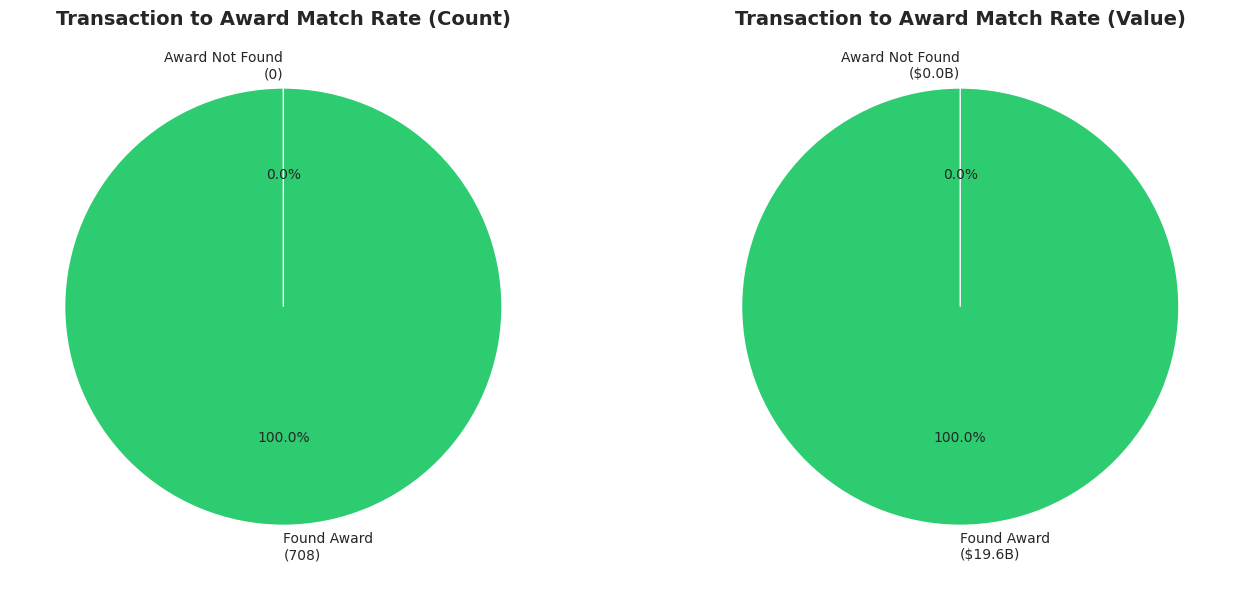

In [13]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# By count
counts = [len(matched), len(not_matched)]
labels = [f'Found Award\n({len(matched):,})', f'Award Not Found\n({len(not_matched):,})']
colors = ['#2ecc71', '#e74c3c']
axes[0].pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Transaction to Award Match Rate (Count)', fontsize=14, fontweight='bold')

# By value
values = [matched_value, not_matched_value]
values_b = [v/1e9 for v in values]
labels_val = [f'Found Award\n(${values_b[0]:.1f}B)', f'Award Not Found\n(${values_b[1]:.1f}B)']
axes[1].pie(values, labels=labels_val, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Transaction to Award Match Rate (Value)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Analyze Unmatched Transactions

Why didn't some transactions find their awards?

In [ ]:
print("=== UNMATCHED TRANSACTIONS ANALYSIS ===")
print(f"\nTotal unmatched: {len(not_matched):,}")

# Show some examples
print("\nSample unmatched transactions:")
print(not_matched[[
    'transaction_id', 'award_id', 'action_date', 'modification_number',
    'federal_action_obligation', 'recipient_name', 'award_type_transaction'
]].head(20))

In [ ]:
# Analyze unmatched by award type
print("=== Unmatched Transactions by Award Type ===")
unmatched_by_type = not_matched.groupby('award_type_transaction').agg({
    'transaction_id': 'count',
    'federal_action_obligation': 'sum'
}).sort_values('transaction_id', ascending=False)
unmatched_by_type.columns = ['Count', 'Total Value']
print(unmatched_by_type)

In [ ]:
# Check dates - maybe the awards are from different time periods?
print("=== Date Range Comparison ===")
print(f"\nTransactions date range:")
print(f"  Min: {transactions_df['action_date'].min()}")
print(f"  Max: {transactions_df['action_date'].max()}")

print(f"\nAwards date range (award_date):")
# Filter out empty strings
award_dates = awards_df[awards_df['award_date'] != '']['award_date']
if len(award_dates) > 0:
    print(f"  Min: {award_dates.min()}")
    print(f"  Max: {award_dates.max()}")
    print(f"  Non-empty award_dates: {len(award_dates)} / {len(awards_df)}")
else:
    print("  No non-empty award_dates found!")

print(f"\nAwards date range (start_date):")
print(f"  Min: {awards_df['start_date'].min()}")
print(f"  Max: {awards_df['start_date'].max()}")

## Analyze Matched Transactions

For transactions that found their award, let's compare the data between transaction and award.

In [ ]:
print("=== MATCHED TRANSACTIONS ANALYSIS ===")
print(f"Total matched: {len(matched):,}")

# Show some examples
print("\nSample matched transactions with awards:")
print(matched[[
    'transaction_id', 'award_id', 'action_date', 
    'federal_action_obligation', 'award_amount',
    'recipient_name_transaction', 'recipient_name_award'
]].head(10))

In [ ]:
# Compare amounts: transaction vs award
# Note: transaction amount is the action amount, award amount is total award amount
print("=== Transaction vs Award Amounts ===")
print(f"\nTransaction amounts (federal_action_obligation):")
print(f"  Mean: ${matched['federal_action_obligation'].mean():,.2f}")
print(f"  Median: ${matched['federal_action_obligation'].median():,.2f}")
print(f"  Total: ${matched['federal_action_obligation'].sum():,.2f}")

print(f"\nAward amounts (award_amount):")
print(f"  Mean: ${matched['award_amount'].mean():,.2f}")
print(f"  Median: ${matched['award_amount'].median():,.2f}")
print(f"  Total: ${matched['award_amount'].sum():,.2f}")

print(f"\nNote: Award amounts are typically larger because they represent")
print(f"the total obligated amount for the entire award, while transaction")
print(f"amounts represent individual actions.")

In [ ]:
# Check if recipient names match
matched['recipient_match'] = matched['recipient_name_transaction'] == matched['recipient_name_award']

print("=== Recipient Name Consistency ===")
print(f"Transactions where recipient names match: {matched['recipient_match'].sum():,} ({matched['recipient_match'].sum()/len(matched)*100:.1f}%)")
print(f"Transactions where recipient names differ: {(~matched['recipient_match']).sum():,} ({(~matched['recipient_match']).sum()/len(matched)*100:.1f}%)")

# Show examples of mismatches
if (~matched['recipient_match']).sum() > 0:
    print("\nExamples of mismatched recipients:")
    mismatched = matched[~matched['recipient_match']][[
        'award_id', 'recipient_name_transaction', 'recipient_name_award'
    ]].head(10)
    print(mismatched.to_string())

## Summary & Key Findings

In [ ]:
print("="*80)
print("KEY FINDINGS: New Transactions to Awards Join Analysis")
print("="*80)

print(f"\n1. DATA VOLUMES")
print(f"   - Total transactions loaded: {len(transactions_df):,}")
print(f"   - New transactions (filtered): {len(new_transactions):,} ({len(new_transactions)/len(transactions_df)*100:.1f}%)")
print(f"   - Total awards loaded: {len(awards_df):,}")

print(f"\n2. MATCH RATE")
print(f"   - Transactions that found their award: {len(matched):,} ({len(matched)/len(new_transactions)*100:.1f}%)")
print(f"   - Transactions that did NOT find award: {len(not_matched):,} ({len(not_matched)/len(new_transactions)*100:.1f}%)")

print(f"\n3. MATCH RATE BY VALUE")
print(f"   - Total value (new transactions): ${total_value:,.2f}")
print(f"   - Matched value: ${matched_value:,.2f} ({matched_value/total_value*100:.1f}%)")
print(f"   - Unmatched value: ${not_matched_value:,.2f} ({not_matched_value/total_value*100:.1f}%)")

print(f"\n4. AWARD ID OVERLAP")
print(f"   - Unique award_ids in new transactions: {new_transactions['award_id'].nunique():,}")
print(f"   - Unique award_ids in awards: {awards_df['award_id'].nunique():,}")
print(f"   - Award IDs in both datasets: {len(overlap):,}")
print(f"   - Award IDs only in transactions: {len(only_in_transactions):,}")

print(f"\n5. DATA CONSISTENCY (for matched records)")
if len(matched) > 0:
    print(f"   - Recipient names match: {matched['recipient_match'].sum():,} ({matched['recipient_match'].sum()/len(matched)*100:.1f}%)")
    print(f"   - Recipient names differ: {(~matched['recipient_match']).sum():,} ({(~matched['recipient_match']).sum()/len(matched)*100:.1f}%)")

print(f"\n6. IMPLICATIONS")
if len(not_matched) > 0:
    not_matched_pct = len(not_matched)/len(new_transactions)*100
    if not_matched_pct > 50:
        print(f"   ⚠️  HIGH MISMATCH RATE: {not_matched_pct:.1f}% of new transactions don't find awards")
        print(f"   - Likely cause: Different time periods or different filtering criteria")
        print(f"   - Awards endpoint uses award-level summaries (rolled up)")
        print(f"   - Transactions endpoint has transaction-level detail")
    else:
        print(f"   ✓ GOOD MATCH RATE: {100-not_matched_pct:.1f}% of new transactions find their awards")
else:
    print(f"   ✓ PERFECT MATCH: All new transactions found their awards!")

print("\n" + "="*80)

## Export Results

In [ ]:
# Export matched and unmatched for further investigation
output_dir = Path('../data/awards')

matched_output = output_dir / 'matched_transactions_to_awards.csv'
unmatched_output = output_dir / 'unmatched_transactions.csv'

# Export matched (with selected columns to avoid duplication)
matched_export = matched[[
    'transaction_id', 'award_id', 'action_date', 'modification_number',
    'federal_action_obligation', 'award_amount',
    'recipient_name_transaction', 'recipient_name_award',
    'award_type_transaction', 'awarding_agency_name_transaction'
]]
matched_export.to_csv(matched_output, index=False)
print(f"Exported {len(matched):,} matched records to: {matched_output}")

# Export unmatched
unmatched_export = not_matched[[
    'transaction_id', 'award_id', 'action_date', 'modification_number',
    'federal_action_obligation', 'recipient_name_transaction',
    'award_type_transaction', 'awarding_agency_name_transaction',
    'award_description'
]]
unmatched_export.to_csv(unmatched_output, index=False)
print(f"Exported {len(not_matched):,} unmatched records to: {unmatched_output}")